In [23]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

In [24]:
def zero_pad(X, pad):#sıfırla padding yapıyoruz
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=0)
    return X_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


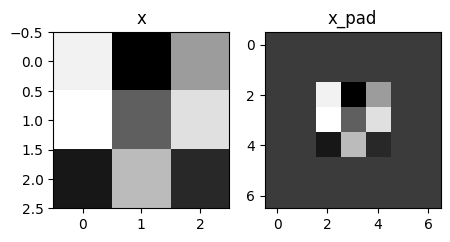

In [25]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])

fig ,axarr = plt.subplots(1,2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

In [26]:
def conv_single_step(a_slice_prev, W, b):
    """
    Tek bir konvolüsyon adımını gerçekleştirir.

    Parametreler:
    a_slice_prev -- Giriş verisinin bir dilimi (n_H_prev, n_W_prev, n_C_prev)
    W -- Ağırlık matrisi (f, f, n_C_prev, n_C)
    b -- Bias değeri (1, 1, 1, n_C)

    Döndürülen değer:
    Z -- Skaler değer, a_slice_prev ve W'nin konvolüsyonu ve bias eklenmesi sonucu elde edilen değer
    """
    # Giriş dilimi (a_slice_prev) ve ağırlık matrisi (W) eleman bazında çarpılır.
    s = np.multiply(a_slice_prev, W) + b

    # Çarpım sonucu elde edilen matrisin tüm elemanları toplanır.
    Z = np.sum(s)

    # Skaler değer döndürülür.
    return Z



In [27]:
# Random sayı üreteci için seed değeri ayarlanır. Bu, her çalıştırmada aynı rastgele değerlerin üretilmesini sağlar.
np.random.seed(1)

# Boyutu (4, 4, 3) olan rastgele bir giriş dilimi (a_slice_prev) oluşturulur.
# Bu, 4x4 boyutunda ve 3 kanallı (örneğin RGB) bir görüntü dilimi olarak düşünülebilir.
a_slice_prev = np.random.randn(4, 4, 3)

# Boyutu (4, 4, 3) olan rastgele bir ağırlık matrisi (W) oluşturulur.
# Bu, giriş dilimiyle aynı boyutta olduğu için eleman bazında çarpım yapılabilir.
W = np.random.randn(4, 4, 3)

# Boyutu (1, 1, 1) olan rastgele bir bias değeri (b) oluşturulur.
# Bu, konvolüsyon sonucuna eklenir.
b = np.random.randn(1, 1, 1)

# conv_single_step fonksiyonu çağrılır ve a_slice_prev, W ve b değerleri kullanılarak konvolüsyon işlemi gerçekleştirilir.
# Sonuç olarak Z değeri hesaplanır.
Z = conv_single_step(a_slice_prev, W, b)

# Hesaplanan Z değeri ekrana yazdırılır.
print("Z =", Z)

Z = -23.16021220252078


In [28]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Konvolüsyonel katmanın ileri yayılım (forward propagation) adımını gerçekleştirir.

    Parametreler:
    A_prev -- Giriş verisi (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Ağırlık matrisi (f, f, n_C_prev, n_C)
    b -- Bias değerleri (1, 1, 1, n_C)
    hparameters -- Hiperparametreler (stride ve pad değerlerini içeren sözlük)

    Döndürülen değerler:
    Z -- Konvolüsyon sonucu (m, n_H, n_W, n_C)
    cache -- İleri yayılım için gerekli değerler (A_prev, W, b, hparameters)
    """

    # Giriş verisinin boyutları alınır.
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    # Ağırlık matrisinin boyutları alınır.
    (f, f, n_C_prev, n_C) = W.shape

    # Hiperparametrelerden stride ve pad değerleri alınır.
    stride = hparameters["stride"]
    pad = hparameters["pad"]

    # Çıkış boyutları hesaplanır.
    n_H = int(((n_H_prev - f + 2 * pad) / stride) + 1)
    n_W = int(((n_W_prev - f + 2 * pad) / stride) + 1)

    # Çıkış matrisi (Z) sıfırlarla başlatılır.
    Z = np.zeros((m, n_H, n_W, n_C))

    # Giriş verisine padding (dolgu) uygulanır.
    A_prev_pad = zero_pad(A_prev, pad)

    # Her bir örnek için döngü başlatılır.
    for i in range(m):
        a_prev_pad = A_prev_pad[i]  # i. örneğin padding uygulanmış hali

        # Çıkış yüksekliği (n_H) boyunca döngü başlatılır.
        for h in range(n_H):
            # Çıkış genişliği (n_W) boyunca döngü başlatılır.
            for w in range(n_W):
                # Çıkış kanalı (n_C) boyunca döngü başlatılır.
                for c in range(n_C):

                    # Dilimleme (slicing) için başlangıç ve bitiş indeksleri hesaplanır.
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f

                    # Giriş dilimi (a_prev_pad) üzerinde dilimleme yapılır.
                    s_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    # Tek bir konvolüsyon adımı gerçekleştirilir ve sonuç Z'ye kaydedilir.
                    Z[i, h, w, c] = conv_single_step(s_slice_prev, W[..., c], b[..., c])

    # Çıkış boyutlarının doğru olduğu kontrol edilir.
    assert(Z.shape == (m, n_H, n_W, n_C))

    # İleri yayılım için gerekli değerler cache'de saklanır.
    cache = (A_prev, W, b, hparameters)

    return Z, cache

In [29]:
# Rastgele sayı üretiminin tekrar edilebilir olması için sabit bir tohum değeri belirleniyor
np.random.seed(1)

# Giriş özelliği haritası (A_prev) rastgele değerlerle başlatılıyor
# Boyut: (10, 4, 4, 3) -> 10 örnek, 4x4 uzaysal boyutlar, 3 kanal
A_prev = np.random.randn(10, 4, 4, 3)

# Filtre ağırlıkları (W) rastgele değerlerle başlatılıyor
# Boyut: (2, 2, 3, 8) -> Her biri 2x2 boyutunda ve 3 kanallı 8 filtre
W = np.random.randn(2, 2, 3, 8)

# Her filtre için bias değerleri (b) rastgele değerlerle başlatılıyor
# Boyut: (1, 1, 1, 8) -> Her filtre için bir bias
b = np.random.randn(1, 1, 1, 8)

# Hiperparametreler: sıfır dolgu (padding) ve adım boyutu (stride)
hparameters = {"pad": 2,
               "stride": 2}

# Konvolüsyon işlemi çağrılıyor
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

# Sonuçların ortalaması ve bazı belirli değerler yazdırılıyor
print("np.mean(Z) = ", np.mean(Z))
print("Z[3,2,1] =", Z[3,2,1])
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])


np.mean(Z) =  0.2020415821314338
Z[3,2,1] = [ 3.48211796 -8.37731144 -4.56894114 13.867986   12.1423875  -6.39349327
 -7.06247915  8.01747414]
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


In [30]:
def pool_forward(A_prev, hparameters, mode="max"):
    # Giriş tensörünün boyutlarını al (örnek sayısı, yükseklik, genişlik, kanal sayısı)
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    # Hiperparametrelerden filtre boyutu (f) ve adım boyutunu (stride) al
    f = hparameters["f"]
    stride = hparameters["stride"]

    # Çıkış tensörünün boyutlarını hesapla
    n_H = int(1 + (n_H_prev - f) / stride)  # Çıkış yüksekliği
    n_W = int(1 + (n_W_prev - f) / stride)  # Çıkış genişliği
    n_C = n_C_prev  # Kanal sayısı değişmez

    # Çıkış tensörünü sıfırlarla başlat
    A = np.zeros((m, n_H, n_W, n_C))

    # Mini batch'teki her örnek (m), her uzaysal boyut (h, w) ve her kanal (c) için
    for i in range(m):  # Örnekler üzerinde döngü
        for h in range(n_H):  # Uzaysal yükseklik üzerinde döngü
            for w in range(n_W):  # Uzaysal genişlik üzerinde döngü
                for c in range(n_C):  # Kanallar üzerinde döngü

                    # Filtrenin başlangıç ve bitiş koordinatlarını hesapla
                    vert_start = h * stride  # Dikey başlangıç
                    vert_end = vert_start + f  # Dikey bitiş
                    horiz_start = w * stride  # Yatay başlangıç
                    horiz_end = horiz_start + f  # Yatay bitiş

                    # Giriş tensöründen bu koordinatlardaki alt bölgeyi seç
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]

                    # Maksimum havuzlama modunda, seçilen bölgedeki maksimum değeri al
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)

                    # Ortalama havuzlama modunda, seçilen bölgedeki ortalama değeri al
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)

    # Giriş tensörünü ve hiperparametreleri cache'e kaydet (geri yayılım için)
    cache = (A_prev, hparameters)

    # Çıkış tensörünün boyutunun beklenenle aynı olduğunu doğrula
    assert(A.shape == (m, n_H, n_W, n_C))

    # Havuzlama sonucu (A) ve cache'i döndür
    return A, cache


In [31]:
# Rastgele sayı üretiminin tekrar edilebilir olması için sabit bir tohum değeri belirleniyor
np.random.seed(1)

# Giriş verisi (A_prev) rastgele değerlerle oluşturuluyor
# Boyut: (2, 4, 4, 3) -> 2 örnek, 4x4 uzaysal boyutlar, 3 kanal
A_prev = np.random.randn(2, 4, 4, 3)

# Hiperparametreler: filtre boyutu (f) ve adım boyutu (stride) belirleniyor
hparameters = {"f": 3, "stride": 2}

# Maksimum havuzlama (max pooling) işlemi çağrılıyor
A, cache = pool_forward(A_prev, hparameters)
print("mode = max")  # Havuzlama modunu belirtiyor
print("A =", A)  # Maksimum havuzlama sonucunu yazdırıyor
print("**************************************")

# Ortalama havuzlama (average pooling) işlemi çağrılıyor
A, cache = pool_forward(A_prev, hparameters, mode="average")
print("mode = average")  # Havuzlama modunu belirtiyor
print("A =", A)  # Ortalama havuzlama sonucunu yazdırıyor




mode = max
A = [[[[1.74481176 0.86540763 1.13376944]]]


 [[[1.13162939 1.51981682 2.18557541]]]]
**************************************
mode = average
A = [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]


## Geri yayılım

In [32]:
def conv_backward(dZ, cache):
    # İleri yayılımda kaydedilen bilgiler cache'den çıkarılıyor
    (A_prev, W, b, hparameters) = cache

    # Giriş verisinin boyutları
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    # Filtrelerin boyutları
    (f, f, n_C_prev, n_C) = W.shape

    # Hiperparametreler: adım boyutu (stride) ve sıfır dolgu (pad)
    stride = hparameters["stride"]
    pad = hparameters["pad"]

    # dZ'nin boyutları (geri yayılımda hata gradyanının şekli)
    (m, n_H, n_W, n_C) = dZ.shape

    # Geri yayılım için gradyan matrisleri sıfırlarla başlatılıyor
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))  # Giriş verisinin gradyanı
    dW = np.zeros((f, f, n_C_prev, n_C))  # Filtrelerin gradyanı
    db = np.zeros((1, 1, 1, n_C))  # Bias değerlerinin gradyanı

    # Sıfır dolgu uygulanarak giriş verisi ve gradyan matrisleri genişletiliyor
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)

    # Mini batch'teki her örnek için döngü
    for i in range(m):
        # İlgili örneğin sıfır dolgulu giriş verisi ve gradyan matrisleri
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]

        # Uzaysal boyutlar üzerinde döngü (yükseklik ve genişlik)
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    # Filtrenin ilgili bölgeyi kapladığı alanın başlangıç ve bitiş koordinatları
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f

                    # Giriş verisinden ilgili bölgeyi al
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    # Gradyan hesaplamaları
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:, :, :, c] * dZ[i, h, w, c]
                    dW[:, :, :, c] += a_slice * dZ[i, h, w, c]
                    db[:, :, :, c] += dZ[i, h, w, c]

        # Sıfır dolgu kaldırılarak gradyan güncelleniyor
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]

    # Gradyan matrislerinin şekilleri doğrulanıyor
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))

    # Geri yayılım sonucu gradyanlar döndürülüyor
    return dA_prev, dW, db


In [33]:
# Rastgele sayı üretiminin tekrar edilebilir olması için sabit bir tohum değeri belirleniyor
np.random.seed(1)

# Geri yayılım işlemi için conv_backward fonksiyonu çağrılıyor
# dA: giriş verisinin gradyanı, dW: filtrelerin gradyanı, db: bias değerlerinin gradyanı
dA, dW, db = conv_backward(Z, cache_conv)

# Giriş verisinin gradyanının (dA) ortalaması yazdırılıyor
print("dA_mean =", np.mean(dA))

# Filtrelerin gradyanının (dW) ortalaması yazdırılıyor
print("dW_mean =", np.mean(dW))

# Bias değerlerinin gradyanının (db) ortalaması yazdırılıyor
print("db_mean =", np.mean(db))


dA_mean = -0.8661122901903908
dW_mean = 1.6265531153487132
db_mean = 32.32665314102948


In [34]:
def create_mask_from_window(x):
    # Giriş olarak verilen pencerenin (x) maksimum değerine eşit olan elemanları işaretleyen bir maske oluşturuluyor
    mask = x == np.max(x)
    return mask  # Oluşturulan maske döndürülüyor


In [35]:
# Rastgele sayı üretiminin tekrar edilebilir olması için sabit bir tohum değeri belirleniyor
np.random.seed(1)

# Rastgele değerlerle 2x3 boyutunda bir matris oluşturuluyor
x = np.random.randn(2, 3)

# Maksimum değerin yerini belirlemek için maske oluşturuluyor
mask = create_mask_from_window(x)

# Oluşturulan matris yazdırılıyor
print("x = ", x)

# Maksimum değerin konumlarını belirten maske yazdırılıyor
print("mask = ", mask)


x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


In [36]:
def distribute_value(dZ, shape):
    # shape parametresi, değerlerin dağıtılacağı matrisin (yükseklik, genişlik) boyutlarını belirtir
    (n_H, n_W) = shape  # Yükseklik (n_H) ve genişlik (n_W) bilgisi alınır

    # dZ değerini matrisin tüm elemanlarına eşit şekilde dağıtmak için ortalama hesaplanır
    average = dZ / (n_H * n_W)

    # Tüm elemanları 1 olan bir matris oluşturulur ve bu matrise ortalama değer çarpılarak atanır
    A = np.ones(shape) * average

    # Dağıtılmış değerleri içeren matris döndürülür
    return A


In [37]:
a = distribute_value(2, (2,2))
print('distributed value/ dağıtılmış değer =', a)

distributed value/ dağıtılmış değer = [[0.5 0.5]
 [0.5 0.5]]


In [38]:
def pool_backward(dA, cache, mode="max"):
    # Cache içindeki önceki aktivasyonlar (A_prev) ve hiperparametreler (stride, f) alınır
    (A_prev, hparameters) = cache
    stride = hparameters["stride"]  # Adım boyutu (stride) hiperparametresi
    f = hparameters["f"]  # Havuzlama penceresinin boyutu (f)

    # A_prev ve dA'nın boyutları alınır
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape  # Girişin (A_prev) boyutları
    m, n_H, n_W, n_C = dA.shape  # Gradyanın (dA) boyutları

    # A_prev ile aynı boyutlarda bir sıfır matrisi (dA_prev) oluşturulur
    dA_prev = np.zeros(A_prev.shape)

    # Her bir örnek için döngü
    for i in range(m):
        a_prev = A_prev[i]  # Girişin i'inci örneği
        for h in range(n_H):  # Yükseklik boyunca döngü
            for w in range(n_W):  # Genişlik boyunca döngü
                for c in range(n_C):  # Kanal boyunca döngü

                    # Havuzlama penceresinin başlangıç ve bitiş sınırları belirlenir
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f

                    # Maksimum havuzlama modu
                    if mode == "max":
                        # Pencerenin dilimi alınır
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]

                        # Maksimum değerlerin yerini belirlemek için maske oluşturulur
                        mask = create_mask_from_window(a_prev_slice)

                        # Maksimum değerin olduğu konumlara gradyan (dA) eklenir
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[i, h, w, c])

                    # Ortalama havuzlama modu
                    elif mode == "average":
                        # Gradyanın değeri (da) alınır
                        da = dA[i, h, w, c]

                        # Havuzlama penceresinin boyutlarına göre gradyan dağıtılır
                        shape = (f, f)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)

    # Geri döndürülen dA_prev boyutlarının A_prev ile uyumlu olduğundan emin olunur
    assert(dA_prev.shape == A_prev.shape)

    # dA_prev döndürülür
    return dA_prev


In [39]:
# Rastgele sayı üretiminin tekrar edilebilir olması için sabit bir tohum değeri belirleniyor
np.random.seed(1)

# 5x5x3x2 boyutlarında rastgele bir A_prev matrisi oluşturuluyor
A_prev = np.random.randn(5, 5, 3, 2)

# Havuzlama penceresi boyutu (f) ve adım (stride) hiperparametreleri belirleniyor
hparameters = {"f": 2, "stride": 1}

# Havuzlama fonksiyonu çağrılarak sonuç (A) ve cache (önceki aktivasyonlar ve hiperparametreler) elde ediliyor
A, cache = pool_forward(A_prev, hparameters)

# Rastgele bir dA matrisi (geri yayılım gradyanı) oluşturuluyor
dA = np.random.randn(5, 4, 2, 2)

# Maksimum havuzlama için geri yayılım hesaplanıyor
dA_prev = pool_backward(dA, cache, mode="max")

# Maksimum havuzlama modunun sonucu yazdırılıyor
print("mode = max")
print('mean of dA = ', np.mean(dA))  # dA'nın ortalaması yazdırılıyor
print('dA_prev[1,1] = ', dA_prev[1, 1])  # dA_prev matrisinin [1,1] elemanı yazdırılıyor

print()

# Ortalama havuzlama için geri yayılım hesaplanıyor
dA_prev = pool_backward(dA, cache, mode="average")

# Ortalama havuzlama modunun sonucu yazdırılıyor
print("mode = average")
print('mean of dA = ', np.mean(dA))  # dA'nın ortalaması yazdırılıyor
print('dA_prev[1,1] = ', dA_prev[1, 1])  # dA_prev matrisinin [1,1] elemanı yazdırılıyor


mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
